In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

In [ ]:
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [ ]:
for category in range(4):
    images = [img_to_array(load_img(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}/{file}', color_mode='grayscale', target_size=(360, 480))) for file in os.listdir(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}')]

    labels = [category] * len(images)

    train_images_category, test_images_category, train_labels_category, test_labels_category = train_test_split(images, labels, test_size=0.2)

    train_images.extend(train_images_category)
    test_images.extend(test_images_category)
    train_labels.extend(train_labels_category)
    test_labels.extend(test_labels_category)

In [ ]:
x_train = np.array(train_images)
x_test = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [ ]:
print(x_train.shape[1])

360


RESTNET

In [ ]:
start_time = time.time()


In [ ]:
from tensorflow.keras.applications import ResNet50


In [ ]:
x_train = np.array([np.repeat(img, 3, axis=-1) for img in x_train])
x_test = np.array([np.repeat(img, 3, axis=-1) for img in x_test])

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
resnet_model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])


In [ ]:
resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_resnet = resnet_model.fit(x_train, train_labels, epochs=200, validation_data=(x_test, test_labels))


Epoch 1/200
24/24 [==============================] - 21s 346ms/step - loss: 1.4063 - accuracy: 0.3239 - val_loss: 1.3611 - val_accuracy: 0.2513
Epoch 2/200
24/24 [==============================] - 4s 152ms/step - loss: 1.3117 - accuracy: 0.3752 - val_loss: 1.2845 - val_accuracy: 0.3262
Epoch 3/200
24/24 [==============================] - 3s 145ms/step - loss: 1.2823 - accuracy: 0.4049 - val_loss: 1.2603 - val_accuracy: 0.3904
Epoch 4/200
24/24 [==============================] - 4s 180ms/step - loss: 1.2374 - accuracy: 0.4494 - val_loss: 1.2148 - val_accuracy: 0.4813
Epoch 5/200
24/24 [==============================] - 4s 183ms/step - loss: 1.2280 - accuracy: 0.4764 - val_loss: 1.1961 - val_accuracy: 0.4920
Epoch 6/200
24/24 [==============================] - 4s 178ms/step - loss: 1.1761 - accuracy: 0.4710 - val_loss: 1.1973 - val_accuracy: 0.4706
Epoch 7/200
24/24 [==============================] - 4s 170ms/step - loss: 1.1555 - accuracy: 0.4791 - val_loss: 1.1420 - val_accuracy: 0.486

6/6 [==============================] - 1s 125ms/step - loss: 0.4277 - accuracy: 0.8610


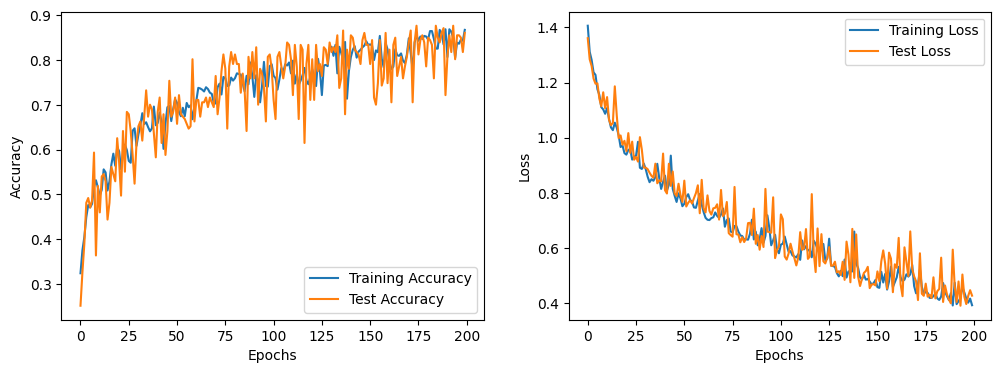

In [ ]:
test_loss, test_acc = resnet_model.evaluate(x_test, test_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
predictions_resnet = resnet_model.predict(x_test)
binary_predictions_resnet = np.argmax(predictions_resnet, axis=1)
test_labels = test_labels.reshape(-1, 1)
# Calculate metrics
conf_matrix_resnet = confusion_matrix(test_labels, binary_predictions_resnet)
accuracy_resnet = np.trace(conf_matrix_resnet) / np.sum(conf_matrix_resnet)
precision_resnet = np.diagonal(conf_matrix_resnet) / np.sum(conf_matrix_resnet, axis=0)
recall_resnet = np.diagonal(conf_matrix_resnet) / np.sum(conf_matrix_resnet, axis=1)
f1_score_resnet = 2 * (precision_resnet * recall_resnet) / (precision_resnet + recall_resnet)

# Specificity
num_classes_resnet = len(conf_matrix_resnet)
specificity_resnet = []
for i in range(num_classes_resnet):
    true_negatives_resnet = np.sum(conf_matrix_resnet) - np.sum(conf_matrix_resnet[i, :]) - np.sum(conf_matrix_resnet[:, i]) + conf_matrix_resnet[i, i]
    false_positives_resnet = np.sum(conf_matrix_resnet[:, i]) - conf_matrix_resnet[i, i]
    specificity_class_resnet = true_negatives_resnet / (true_negatives_resnet + false_positives_resnet)
    specificity_resnet.append(specificity_class_resnet)

average_specificity_resnet = np.mean(specificity_resnet)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_resnet)

# Print the metrics
print(f"Accuracy: {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet}")
print(f"Recall: {recall_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Specificity for each class: {specificity_resnet}")
print(f"Average Specificity: {average_specificity_resnet}")

6/6 [==============================] - 2s 123ms/step
Confusion Matrix:
[[48  0  0  0]
 [ 6 31  6  4]
 [ 0  2 29  4]
 [ 2  0  2 53]]
Accuracy: 0.8610
Precision: [0.85714286 0.93939394 0.78378378 0.86885246]
Recall: [1.         0.65957447 0.82857143 0.92982456]
F1 Score: [0.92307692 0.775      0.80555556 0.89830508]
Specificity for each class: [0.9424460431654677, 0.9857142857142858, 0.9473684210526315, 0.9384615384615385]
Average Specificity: 0.9534975720984809


In [ ]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time} seconds.")

Training took 888.9407260417938 seconds.
